## Run default configurations
Print out Psats, NET, NET_wafer

In [14]:
# See what yaml files are locally available.
!ls *.yaml

CHLAT_20210605.yaml    SAT_LFMF_20210623.yaml SAT_pole_20210623.yaml
SAT_HF_20210623.yaml   SAT_pole_20210605.yaml SPLAT_20210605.yaml


In [19]:
# Standard imports
import numpy as np
import yaml
import toml
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline  
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 20]

# bolo-calc import
from bolo import Top

#read fixed PSATs from .toml file
psat_dict = toml.load("FixedPsats.toml")

In [20]:
psat_dict

{'CHLAT_20210605': {'LF_1': 0.686,
  'LF_2': 3.965,
  'MF_1': 4.401,
  'MF_2': 12.199,
  'HF_1': 33.308,
  'HF_2': 47.636},
 'SPLAT_20210605': {'ULF_1': 0.406,
  'LF_1': 0.686,
  'LF_2': 3.965,
  'MF_1': 4.401,
  'MF_2': 12.199,
  'HF_1': 33.308,
  'HF_2': 47.636},
 'SAT_LFMF_20210623': {'LF_1': 1.295,
  'LF_2': 6.014,
  'MF1_1': 7.219,
  'MF2_1': 7.219,
  'MF1_2': 12.432,
  'MF2_2': 12.432},
 'SAT_HF_20210623': {'HF_1': 29.298, 'HF_2': 38.064}}

## Run
Read yaml files, run bolo_calc, store some outputs into dictionary called "data".
Print some outputs to table.

In [28]:
data = {}
yamlfiles = ['CHLAT_20210605.yaml','SPLAT_20210605.yaml','SAT_LFMF_20210623.yaml','SAT_HF_20210623.yaml']
for yamlfile in yamlfiles:
    print(yamlfile)
    data[yamlfile] = {}
    dd = yaml.safe_load(open(yamlfile))
    version_date = str(dd['version']['date'])
    version_telescope = str(dd['version']['name'])
    print('{0:8s}  Popt(pW) Psat(pW)   NET    NET_wafer'.format(version_telescope))
    del dd['version']

    # location of atmosphere file
    dd['sim_config']['config_dir'] = '../../bolo-calc/config'
    
    ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())
    
    #---------
    #convert to Watts
    for channel in ch_names:
        psat_dict[yamlfile.partition('.')[0]][channel] *= 1e-12

    #set psat factor to None & delete psat entry from channel default
    dd['instrument']['channel_default']['psat_factor'] = None
    del dd['instrument']['channel_default']['psat']

    #assign SI psat values at the channel level
    for channel in ch_names:
        dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]['psat'] = psat_dict[yamlfile.partition('.')[0]][channel]
    #---------
    
    # Save some of the defaults things
    data[yamlfile]['defaults']={}
    data[yamlfile]['defaults']['Yield']=dd['instrument']['channel_default']['Yield']
    data[yamlfile]['defaults']['Tc']=dd['instrument']['channel_default']['Tc']
    data[yamlfile]['defaults']['waist_factor']=dd['instrument']['channel_default']['waist_factor']
    data[yamlfile]['defaults']['read_frac']=dd['instrument']['channel_default']['read_frac']
    data[yamlfile]['defaults']['site']=dd['instrument']['site']
    data[yamlfile]['defaults']['elevation']=dd['instrument']['elevation']
    data[yamlfile]['defaults']['pwv']=dd['instrument']['pwv']

    top = Top(**dd)
    top.run()
    
    for chan in top.instrument.tables.keys():
        if chan.split('_')[0] == 'cam' :
            chname = chan.split('_')[2] + '_' + chan.split('_')[3]
            data[yamlfile][chname] = {}
            #
            # Grab things we're going to print and give them short names and store them in the dictionary.
            popt = top.instrument.tables[chan]['opt_power'][0]
            data[yamlfile][chname]['popt'] = popt
            psat = top.instrument.tables[chan]['P_sat'][0]
            data[yamlfile][chname]['psat'] = psat
            net = top.instrument.tables[chan]['NET'][0]
            data[yamlfile][chname]['net'] = net
            netwafer = top.instrument.tables[chan]['NET_arr'][0]
            data[yamlfile][chname]['netwafer'] = netwafer
            #
            # Grab things we're not going to print and store them in the dictionary.
            data[yamlfile][chname]['effic'] = top.instrument.tables[chan]['effic'][0]
            data[yamlfile][chname]['nep_photon'] = top.instrument.tables[chan]['NEP_ph'][0]
            data[yamlfile][chname]['nep_phonon'] = top.instrument.tables[chan]['NEP_bolo'][0]
            data[yamlfile][chname]['nep_readout'] = top.instrument.tables[chan]['NEP_read'][0]
            data[yamlfile][chname]['Gdyn'] = top.instrument.tables[chan]['G'][0]
            data[yamlfile][chname]['corr_fact'] = top.instrument.tables[chan]['corr_fact'][0]
            data[yamlfile][chname]['bandcenter'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['band_center']
            data[yamlfile][chname]['fractional_bandwidth'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['fractional_bandwidth']
            dnu = 0.5*data[yamlfile][chname]['bandcenter']*data[yamlfile][chname]['fractional_bandwidth']
            data[yamlfile][chname]['band_lowedge'] = data[yamlfile][chname]['bandcenter'] - dnu
            data[yamlfile][chname]['band_highedge'] = data[yamlfile][chname]['bandcenter'] + dnu
            print('{0:5s} : {1:8.2f} {2:8.2f} {3:8.2f} {4:8.2f}'.format(chname,popt,psat,net,netwafer) )
    print(' ')
    

CHLAT_20210605.yaml
CHLAT     Popt(pW) Psat(pW)   NET    NET_wafer
LF_1  :     0.23     0.00   212.07    24.20
LF_2  :     1.21     0.00   199.85    22.80
MF_1  :     1.38     0.00   228.62     8.70
MF_2  :     4.29     0.00   271.07    10.31
HF_1  :    12.50     0.00   640.42    23.38
HF_2  :    18.43     0.00  1612.21    58.85
 
SPLAT_20210605.yaml
SPLAT     Popt(pW) Psat(pW)   NET    NET_wafer
ULF_1 :     0.14     0.00   247.98    37.73
LF_1  :     0.23     0.00   213.96    24.41
LF_2  :     1.43     0.00   240.69    27.46
MF_1  :     1.55     0.00   252.92     9.62
MF_2  :     3.84     0.00   246.08     9.36
HF_1  :     9.70     0.00   512.81    18.72
HF_2  :    13.33     0.00  1190.19    43.45
 
SAT_LFMF_20210623.yaml
SAT_LFMF  Popt(pW) Psat(pW)   NET    NET_wafer
LF_1  :     0.52     0.00   139.60    18.14
LF_2  :     2.41     0.00   191.35    24.87
MF1_1 :     2.82     0.00   268.75    17.52
MF1_2 :     4.76     0.00   270.51    17.64
MF2_1 :     2.95     0.00   232.66    15.17


## Make a 4-panel plot.
Popt, Psat, NET, NET_wafer

Text(0.5, 1.0, '20210623')

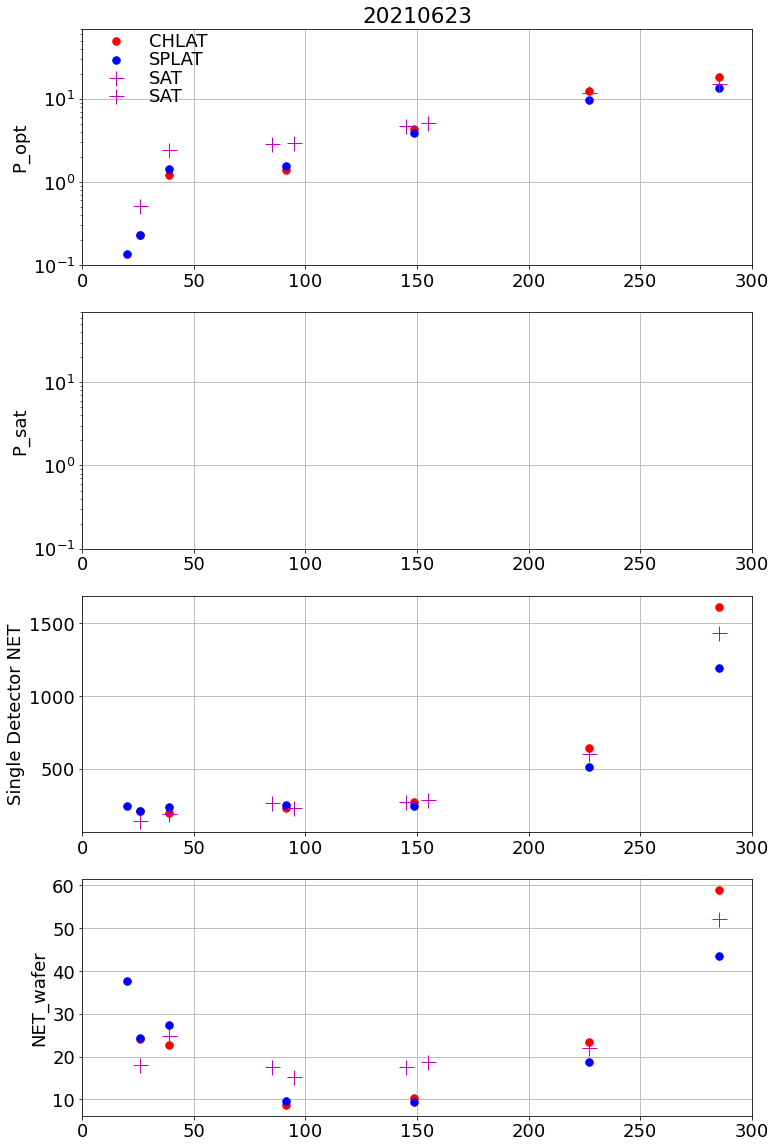

In [29]:
# Plot things vs frequency for each telescope

# Set up a 4-panel plot
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('P_opt')
ax1.set_xlim(0,300)
ax1.set_ylim(0.1,70)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('P_sat')
ax2.set_xlim(0,300)
ax2.set_ylim(0.1,70)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('Single Detector NET')
ax3.set_xlim(0,300)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NET_wafer')
ax4.set_xlim(0,300)
ax4.grid()
yfrac = 0.7

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.semilogy(nu, data[yamlfile][chname]['popt'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['psat'],pointtype, markersize=15 )
            ax3.plot(nu, data[yamlfile][chname]['net'],pointtype, markersize=15 )
            ax4.plot(nu, data[yamlfile][chname]['netwafer'],pointtype, markersize=15 )
            #
    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.05*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.semilogy(xval,yval,pointtype,markersize=15)
    ax1.text(xval+0.05*(xmax-xmin),yval,telescope,verticalalignment='center')
    yfrac = yfrac*0.6


ax1.grid()
ax1.grid()
ax1.set_title(version_date)
    

## Make a 4-panel plot.
efficiency, NEP_photon, NEP_phonon, NEP_readout

Text(0.5, 1.0, '20210623')

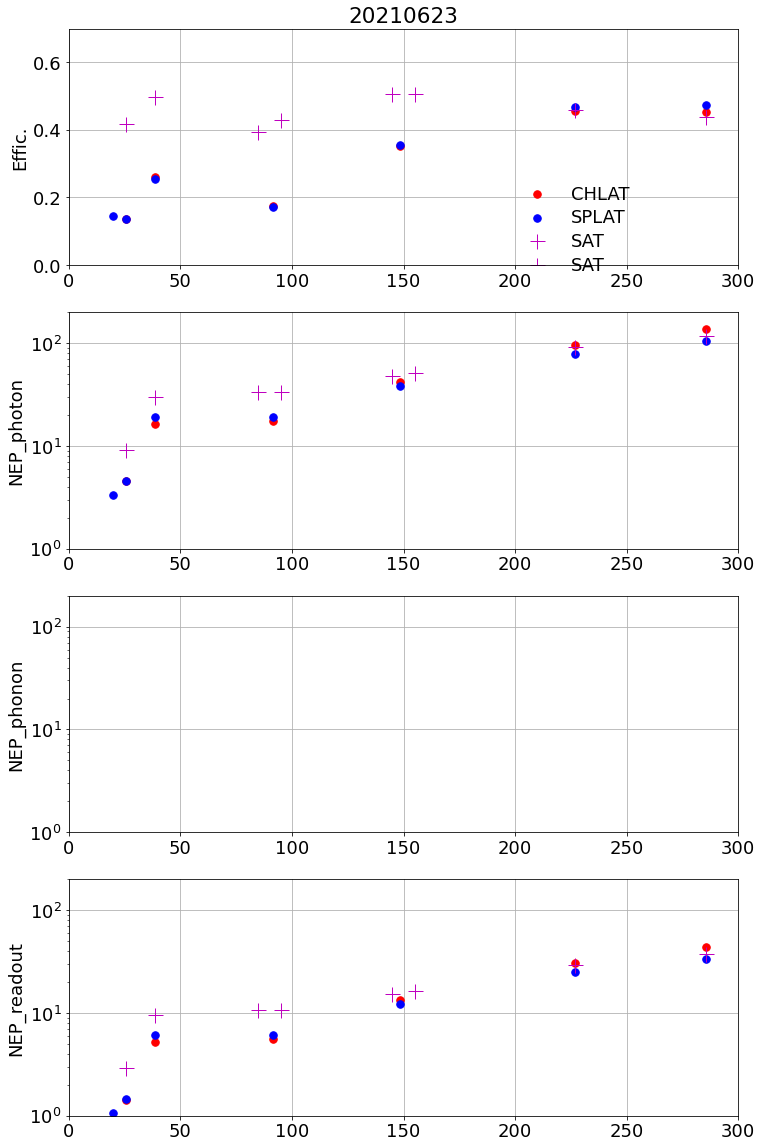

In [30]:
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('Effic.')
ax1.set_xlim(0,300)
ax1.set_ylim(0,0.7)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('NEP_photon')
ax2.set_xlim(0,300)
ax2.set_ylim(1,200)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('NEP_phonon')
ax3.set_xlim(0,300)
ax3.set_ylim(1,200)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NEP_readout')
ax4.set_xlim(0,300)
ax4.set_ylim(1,200)
ax4.grid()

#data = {}
yfrac = 0.3

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.plot(nu, data[yamlfile][chname]['effic'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['nep_photon'],pointtype, markersize=15 )
            ax3.semilogy(nu, data[yamlfile][chname]['nep_phonon'],pointtype, markersize=15 )
            ax4.semilogy(nu, data[yamlfile][chname]['nep_readout'],pointtype, markersize=15 )

    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.7*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.plot(xval,yval,pointtype,markersize=15)
    ax1.text(xval+0.05*(xmax-xmin),yval,telescope,verticalalignment='center')
    yfrac = yfrac-0.1


ax1.grid()
ax1.grid()
ax1.set_title(version_date)



In [31]:
# Write to files
data['runtime'] = datetime.today().strftime('%Y/%m/%d %H:%M:%S')
data['input_id'] = version_date
data['variation'] = 'BaseModel'

# Write to toml file
output_file_name = data['variation'] + '.toml'
with open('outputs/' + output_file_name, "w") as toml_file:
    toml.dump(data, toml_file, encoder=toml.TomlNumpyEncoder())

## Notes
Key lists etc.

In [54]:
top.instrument.tables.keys()

dict_keys(['cam_1_LF_1_sims', 'cam_1_LF_2_sims', 'cam_1_MF1_1_sims', 'cam_1_MF1_2_sims', 'cam_1_MF2_1_sims', 'cam_1_MF2_2_sims', 'cam_1_HF_1_sims', 'cam_1_HF_2_sims', 'optical'])

In [55]:
top.instrument.tables['cam_1_LF_1_sims'].keys()

['effic',
 'opt_power',
 'P_sat',
 'Flink',
 'G',
 'tel_rj_temp',
 'sky_rj_temp',
 'NEP_bolo',
 'NEP_read',
 'NEP_ph',
 'NEP',
 'NET',
 'NET_corr',
 'corr_fact',
 'NET_arr']

In [56]:
data2 = {}
data2['SAT_pole_20210401'] = {'LF_1': 1.40, 'LF_2': 6.13, 'MF1_1': 7.40, 'MF1_2': 12.25, 'MF2_1': 7.65, 'MF2_2': 13.30, 'UHF_1': 29.88, 'UHF_2': 39.03}
data2['SPLAT_20210401'] = {'ULF': 0.42, 'LF_1': 0.69, 'LF_2': 4.32, 'MF_1': 4.65, 'MF_2': 11.49, 'UHF_1': 29.31, 'UHF_2': 40.02}
data2['CHLAT_20210401'] = {'LF_1': 0.72, 'LF_2': 3.84, 'MF_1': 4.47, 'MF_2': 13.95, 'UHF_1': 41.52, 'UHF_2': 60.78}

# Write to toml file
with open('FixedPsats.toml', "w") as toml_file:
    toml.dump(data2, toml_file, encoder=toml.TomlNumpyEncoder())

In [57]:
top.instrument.tables.keys()

dict_keys(['cam_1_LF_1_sims', 'cam_1_LF_2_sims', 'cam_1_MF1_1_sims', 'cam_1_MF1_2_sims', 'cam_1_MF2_1_sims', 'cam_1_MF2_2_sims', 'cam_1_HF_1_sims', 'cam_1_HF_2_sims', 'optical'])

In [58]:
data[yamlfile][chname]['Gdyn']

1098.7025630637945